# Машинное обучение, ФКН ВШЭ #

## Практическое домашнее задание 4. Нейронные сети ##

### Общая информация ###

Дата выдачи: 13.11.2025

Мягкий дедлайн: 21.11.2025 23:59

Жесткий дедлайн: 26.11.2025 23:59

### О задании

В этой работе две независимые части:

- Separable Physics-Informed Neural Network (SPINN) для решения 3D-уравнения Гельмгольца на кубе `[-1, 1]^3` с нулевыми граничными условиями Дирихле. Нужно реализовать дочернюю модель от `BaseModel`, используя архитектуру SPINN (несколько независимых сетей для каждой координаты) и обучить её, минимизируя невязку PDE и ошибку на границе.

- Классификация звуков UrbanSound8K на CNN. Будем извлекать мел-спектрограммы и строить собственную сверточную архитектуру. Оцениваем по accuracy на тесте.

Шаблон (генерация данных, визуализации, проверки) уже дан. Места для вашей работы помечены как `YOUR CODE`.

### Оценивание и штрафы

Максимально допустимая оценка за работу - 10 баллов. 4 балла за SPINN и 6 баллов за CNN.

Задание выполняется самостоятельно. "Похожие" решения считаются плагиатом: все задействованные студенты (в том числе те, у кого списали) получают не более 0 баллов. Если вы использовали внешний источник (даже частично), укажите ссылку в отдельном блоке в конце работы.

Неэффективная реализация кода может негативно отразиться на оценке. Оценка также может быть снижена за плохо читаемый код и плохо оформленные диаграммы/таблицы. Изменять проверочные ячейки и пороги `assert` запрещено.

**Устная проверка.** Для проверки понимания кода и выводов студент может быть приглашён на устную защиту. Оценка за задание может быть изменена после устной защиты. Если студент не может объяснить ключевые части решения и принятые решения, работа считается недобросовестной и оценивается в 0 баллов независимо от автотестов.

### Формат сдачи

Задания сдаются через систему Anytask. Присылать необходимо ноутбук с выполненным заданием, к ноутбуку прикрепите два файла с весами лучшей модели для каждой из двух задач: `best_pinn_model.pth` и `best_cnn_model.pth`. Сам ноутбук называйте в формате `homework-practice-04-dl-Username.ipynb`, где Username - ваша фамилия. Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: ...


In [ ]:
# !pip install pytorch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 scikit-learn==1.3.2 tqdm==4.67.0 matplotlib==3.7.2 soundata

In [ ]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils as vutils

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from typing import Tuple, List
from tqdm.auto import tqdm, trange
from IPython import display

import soundata
import librosa
import librosa.display
from IPython.display import Audio

In [ ]:
torch.manual_seed(1337)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Задание 1. Separable Physics Informed Neural Network для решения уравнения Гельмгольца (4 балла).

Давайте начнем с объяснения, что такое Physics Informed Neural Networks (PINNs).

Physics-Informed Neural Networks (PINNs) - это класс нейросетевых моделей, которые используют не только данные, но и уравнения физики для обучения.

В отличие от обычных нейросетей, PINN оптимизирует функцию потерь, включающую как ошибку на данных (например, граничные и начальные условия), так и невязку дифференциального уравнения (например, уравнения Пуассона).

Таким образом, модель учится решать задачу так, чтобы удовлетворять законам физики.

Это позволяет PINN эффективно работать даже при ограниченном количестве наблюдений, обеспечивая физически осмысленные решения и связывая машинное обучение с методами численного анализа.

### Separable PINN

**Separable PINN (SPINN)** - [https://arxiv.org/pdf/2306.15969] это архитектурная модификация обычных PINN, которая решает фундаментальную проблему: **вычислительную сложность при работе с многомерными PDE**.

Physics-Informed Neural Networks (PINNs) используют не только данные, но и уравнения физики для обучения. Однако для многомерных задач количество коллокационных точек растет экспоненциально ($N^d$), что приводит к огромным вычислительным затратам.

В отличие от классических PINN, где одна нейросеть принимает многомерный вход $(x, y, z, t) \to u$, SPINN использует:

- Несколько отдельных маленьких сетей - по одной для каждой координаты.
- Forward-mode automatic differentiation вместо обратной моды (reverse-mode).
- Факторизуемые координаты - точки коллокации формируют решетку (lattice structure).

Это позволяет экспоненциально сократить количество сетевых операций:

$$
O(N^d) \to O(Nd)
$$

где $N$ - разрешение по каждой оси, $d$ - размерность задачи.


### Архитектура SPINN

Для $d$-мерной задачи SPINN состоит из двух ключевых компонентов:

#### 1. Body Networks (независимые сети для каждой координаты)

$$
f^{(\theta_i)}: \mathbb{R} \to \mathbb{R}^r, \quad i = 1, 2, \ldots, d
$$

где:
- $f^{(\theta_i)}$ - $i$-я body-сеть (MLP с параметрами $\theta_i$)
- Каждая сеть обрабатывает только одну координату ($x_1$, $x_2$, ..., или $x_d$)
- $r$ - ранг декомпозиции (размер выходного вектора признаков)

#### 2. Feature Merging (CP-декомпозиция тензора)

Финальное решение получается через простую операцию произведения и суммирования:

$$
\hat{u}(x_1, x_2, \ldots, x_d) = \sum_{j=1}^{r} \prod_{i=1}^{d} f_j^{(\theta_i)}(x_i)
$$

где:
- $f_j^{(\theta_i)}(x_i)$ - $j$-я компонента выхода $i$-й body-сети
- $r$ - ранг декомпозиции (количество суммируемых членов)

**Интерпретация.** Это аналог CP-декомпозиции (Canonical Polyadic decomposition) тензора - решение представляется как сумма $r$ тензоров ранга 1:

$$
\hat{u} = \sum_{j=1}^{r} \mathbf{f}_j^{(1)} \otimes \mathbf{f}_j^{(2)} \otimes \cdots \otimes \mathbf{f}_j^{(d)}
$$

Уравнение Гельмгольца в трехмерном случае имеет вид:

$$
\nabla^2 u(x, y, z) + k^2 u(x, y, z) = q(x, y, z), \quad (x,y,z) \in \Omega
$$

где:
- $u(x,y,z)$ - неизвестная функция (амплитуда волны)
- $k$ - волновое число
- $q(x,y,z)$ - правая часть (источник)
- на границе области $\partial \Omega$ задаются граничные условия: $u = 0$

### Аналитическое решение:

Для тестирования модели используется:

$$
u(x,y,z) = \sin(a_1\pi x) \cdot \sin(a_2\pi y) \cdot \sin(a_3\pi z)
$$

где в коде: $a_1 = 1$, $a_2 = 1$, $a_3 = 1$.

Метод `reference_solution(x, y, z)`:

```python
def reference_solution(self, x, y, z):
    return (torch.sin(self.a1 * np.pi * x) *
            torch.sin(self.a2 * np.pi * y) *
            torch.sin(self.a3 * np.pi * z))
```


### Источник (правая часть):

Источник $q(x,y,z)$ получается подстановкой аналитического решения в уравнение Гельмгольца:

$$
q(x,y,z) = \nabla^2 u + k^2 u = \left[-(a_1\pi)^2 - (a_2\pi)^2 - (a_3\pi)^2 + k^2\right] u(x,y,z)
$$

Метод `function_of_source(x, y, z)`:

```python
def function_of_source(self, x, y, z):
    u = self.reference_solution(x, y, z)
    laplacian_coef = -(self.a1 * np.pi)**2 - (self.a2 * np.pi)**2 - (self.a3 * np.pi)**2
    return (laplacian_coef + self.k**2) * u
```


### Граничные условия:

На всех 6 гранях куба $\Omega = [-1, 1]^3$ задаются нулевые граничные условия Дирихле:

$$
u(x,y,z) = 0, \quad (x,y,z) \in \partial \Omega
$$

Это соответствует физическому условию отсутствия волны на границе (например, жесткое закрепление мембраны).


In [ ]:
def helmholtz3d_exact_u(a1, a2, a3, x, y, z):
    return torch.sin(a1*torch.pi*x) * torch.sin(a2*torch.pi*y) * torch.sin(a3*torch.pi*z)

In [ ]:
def relative_l2(u_pred, u_true):
    """Относительная L2 ошибка: ||u_pred - u_true|| / ||u_true||"""
    return torch.linalg.norm(u_pred - u_true) / torch.linalg.norm(u_true)

def plot_helmholtz3d(x, y, z, u):
    x = x.detach().cpu().numpy().flatten()
    y = y.detach().cpu().numpy().flatten()
    z = z.detach().cpu().numpy().flatten()
    u = u.detach().cpu().numpy().flatten()

    u_norm = (u - u.min()) / (u.max() - u.min())

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Ключевые изменения
    scatter = ax.scatter(x, y, z, c=u_norm,
                        s=1,
                        cmap='seismic',
                        vmin=0, vmax=1,
                        alpha=0.75,
                        edgecolors='none')

    ax.set_title('U(x, y, z)', fontsize=20)
    ax.set_xlabel('x', fontsize=18, labelpad=10)
    ax.set_ylabel('y', fontsize=18, labelpad=10)
    ax.set_zlabel('z', fontsize=18, labelpad=10)

    cbar = plt.colorbar(scatter, shrink=0.8, aspect=15)
    cbar.set_label('u(x,y,z)', fontsize=16)

    plt.tight_layout()
    plt.show()


def plot_losses(loss_history, residual_history, boundary_history,
                error_history, log_iter, title_prefix=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.semilogy(loss_history, label='Total Loss', linewidth=2)
    ax1.semilogy(residual_history, label='Residual Loss', alpha=0.7)
    ax1.semilogy(boundary_history, label='Boundary Loss', alpha=0.7)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss (log scale)')
    ax1.set_title(f'{title_prefix}Training Losses')

    iterations = np.arange(0, len(error_history) * log_iter, log_iter)
    ax2.semilogy(iterations, error_history, 'r-', linewidth=2, label='Relative L2 Error')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Error (log scale)')
    ax2.set_title(f'{title_prefix}Relative L2 Error')

    plt.tight_layout()
    plt.show()


def compute_error_on_grid(model, x_grid, y_grid, z_grid, u_true):
    """Вычисление ошибки на гриде"""
    with torch.no_grad():
        model.eval()

        # Создаем coordinates tensor из сетки
        coords = torch.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()], dim=1)
        u_pred = model(coords)
        error = relative_l2(u_pred, u_true.flatten())
        model.train()
    return error, u_pred.reshape(x_grid.shape)


def resample_collocation_points(model, NC, domain_size=1.0):
    """
    Ресэмплирование коллокационных точек (как в статье SPINN).
    """
    # Факторизуемые координаты (lattice structure)
    N_per_axis = int(NC ** (1/3))  # Кубический корень для 3D

    x = torch.linspace(-domain_size, domain_size, N_per_axis, device=model.device)
    y = torch.linspace(-domain_size, domain_size, N_per_axis, device=model.device)
    z = torch.linspace(-domain_size, domain_size, N_per_axis, device=model.device)

    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')

    xc = xx.flatten()
    yc = yy.flatten()
    zc = zz.flatten()

    xc.requires_grad_(True)
    yc.requires_grad_(True)
    zc.requires_grad_(True)

    return xc, yc, zc

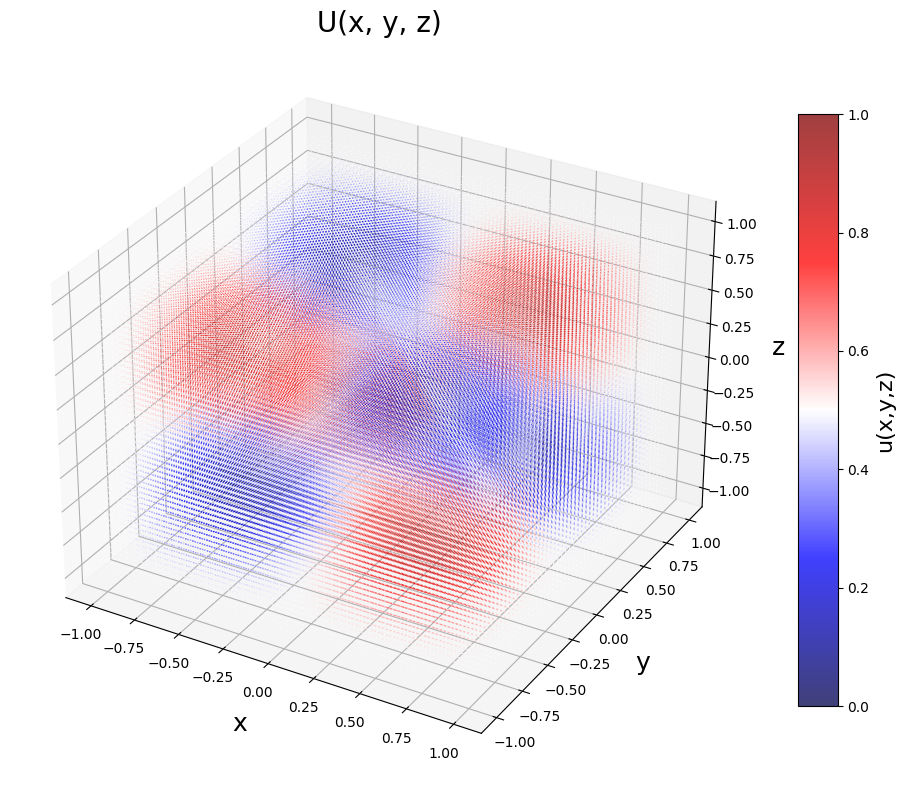

In [ ]:
N_test = 50
x_test = torch.linspace(-1, 1, N_test, device=device)
y_test = torch.linspace(-1, 1, N_test, device=device)
z_test = torch.linspace(-1, 1, N_test, device=device)

xx_test, yy_test, zz_test = torch.meshgrid(x_test, y_test, z_test, indexing='ij')

u_test = helmholtz3d_exact_u(1, 1, 1, xx_test, yy_test, zz_test)

plot_helmholtz3d(xx_test, yy_test, zz_test, u_test)

### Задание 1 (2 балла).

Написать дочерний класс от `BaseModel`, который сможет решить уравнение Гельмгольца 3D.

В `BaseModel` ничего менять не надо.

Требуется реализовать 3 независимые Body-network и уравнение 5 из статьи https://arxiv.org/pdf/2306.15969:

$$u(x,y,z) = \sum_{j=1}^r \left[ f_j^{(1)}(x) \cdot f_j^{(2)}(y) \cdot f_j^{(3)}(z) \right]$$
        
где $f^{(i)}$ - это i-я body-сеть, $f_j^{(i)}$ - j-я компонента её выхода.

In [ ]:
class BaseModel(nn.Module):
    """
    Базовая модель для 3D уравнения Гельмгольца на кубе [-1,1]³.

    PDE:  ∇²u(x,y,z) + k²u(x,y,z) = q(x,y,z)
    BC:   u(x,y,z) = 0 на каждой из 6 граней куба.

    Manufactured solution: u = sin(a₁πx)sin(a₂πy)sin(a₃πz)
    """

    def __init__(self,
                 x_min: float = -1., x_max: float = 1.,
                 y_min: float = -1., y_max: float = 1.,
                 z_min: float = -1., z_max: float = 1.,
                 k: float = 1.0,
                 a1: int = 1, a2: int = 1, a3: int = 1,
                 N: int = 32,
                 device: torch.device = None):
        super().__init__()
        self.x_min, self.x_max = x_min, x_max
        self.y_min, self.y_max = y_min, y_max
        self.z_min, self.z_max = z_min, z_max
        self.N = N
        self.k = k  # волновое число
        self.a1, self.a2, self.a3 = a1, a2, a3
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.mse = nn.MSELoss(reduction="mean")

        # Граничные точки (6 граней куба)
        self._init_boundary_points()

    def _init_boundary_points(self):
        """Инициализация точек на 6 гранях куба."""
        N = self.N

        # Создаем линейные сетки для каждой оси
        lin_x = torch.linspace(self.x_min, self.x_max, N)
        lin_y = torch.linspace(self.y_min, self.y_max, N)
        lin_z = torch.linspace(self.z_min, self.z_max, N)

        # Грань 1: x = x_min (левая грань)
        yy, zz = torch.meshgrid(lin_y, lin_z, indexing='ij')
        x_bc1 = torch.full_like(yy, self.x_min).reshape(-1, 1)
        y_bc1 = yy.reshape(-1, 1)
        z_bc1 = zz.reshape(-1, 1)

        # Грань 2: x = x_max (правая грань)
        yy, zz = torch.meshgrid(lin_y, lin_z, indexing='ij')
        x_bc2 = torch.full_like(yy, self.x_max).reshape(-1, 1)
        y_bc2 = yy.reshape(-1, 1)
        z_bc2 = zz.reshape(-1, 1)

        # Грань 3: y = y_min (нижняя грань)
        xx, zz = torch.meshgrid(lin_x, lin_z, indexing='ij')
        x_bc3 = xx.reshape(-1, 1)
        y_bc3 = torch.full_like(xx, self.y_min).reshape(-1, 1)
        z_bc3 = zz.reshape(-1, 1)

        # Грань 4: y = y_max (верхняя грань)
        xx, zz = torch.meshgrid(lin_x, lin_z, indexing='ij')
        x_bc4 = xx.reshape(-1, 1)
        y_bc4 = torch.full_like(xx, self.y_max).reshape(-1, 1)
        z_bc4 = zz.reshape(-1, 1)

        # Грань 5: z = z_min (передняя грань)
        xx, yy = torch.meshgrid(lin_x, lin_y, indexing='ij')
        x_bc5 = xx.reshape(-1, 1)
        y_bc5 = yy.reshape(-1, 1)
        z_bc5 = torch.full_like(xx, self.z_min).reshape(-1, 1)

        # Грань 6: z = z_max (задняя грань)
        xx, yy = torch.meshgrid(lin_x, lin_y, indexing='ij')
        x_bc6 = xx.reshape(-1, 1)
        y_bc6 = yy.reshape(-1, 1)
        z_bc6 = torch.full_like(xx, self.z_max).reshape(-1, 1)

        # Регистрируем как buffers
        for i, (x_bc, y_bc, z_bc) in enumerate([
            (x_bc1, y_bc1, z_bc1), (x_bc2, y_bc2, z_bc2),
            (x_bc3, y_bc3, z_bc3), (x_bc4, y_bc4, z_bc4),
            (x_bc5, y_bc5, z_bc5), (x_bc6, y_bc6, z_bc6)
        ], 1):
            coords = torch.cat([x_bc, y_bc, z_bc], dim=-1).to(self.device)
            self.register_buffer(f"coords_bc{i}", coords)
            self.register_buffer(f"zeros_bc{i}", torch.zeros(coords.shape[0], 1).to(self.device))

    # Физика задачи
    def reference_solution(self, x, y, z):
        """
        Аналитическое решение (manufactured solution):
        u(x,y,z) = sin(a₁πx) * sin(a₂πy) * sin(a₃πz)
        """
        return (torch.sin(self.a1 * np.pi * x) *
                torch.sin(self.a2 * np.pi * y) *
                torch.sin(self.a3 * np.pi * z))

    def function_of_source(self, x, y, z):
        """
        Правая часть q(x,y,z), полученная из точного решения:
        Из уравнения Гельмгольца: ∇²u + k²u = q
        Подставляя manufactured solution:
        q = -(a₁π)²u - (a₂π)²u - (a₃π)²u + k²u
        """
        u = self.reference_solution(x, y, z)
        laplacian_term = (-(self.a1 * np.pi)**2 -
                         (self.a2 * np.pi)**2 -
                         (self.a3 * np.pi)**2) * u
        return laplacian_term + self.k**2 * u

    def calculate_loss(self, states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        states: (B, 3) с колонками [x, y, z]
        Возвращает (loss_PDE, loss_BC)
        """
        x, y, z = states[:, 0], states[:, 1], states[:, 2]
        loss_pde = self.calculate_pde_loss(x, y, z)
        loss_bc = self.calculate_bc_loss()
        return loss_pde, loss_bc

    def calculate_pde_loss(self, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        MSE по PDE-резидуалу: r = ∇²u + k²u - q(x,y,z)

        Использует forward-mode AD для эффективного вычисления производных.
        В статье показано, что для SPINN forward-mode быстрее reverse-mode!

        Уравнение Гельмгольца:
        ∂²u/∂x² + ∂²u/∂y² + ∂²u/∂z² + k²u = q
        """
        # Клонируем и требуем градиенты для forward-mode AD
        x = x.clone().detach().requires_grad_(True)
        y = y.clone().detach().requires_grad_(True)
        z = z.clone().detach().requires_grad_(True)

        # Формируем координаты и вычисляем u
        coords = torch.stack([x, y, z], dim=1)  # (B, 3)
        u = self.forward(coords)  # (B,)

        # Первые производные (используем forward-mode AD)
        u_x = self._compute_gradient(u, x)  # ∂u/∂x
        u_y = self._compute_gradient(u, y)  # ∂u/∂y
        u_z = self._compute_gradient(u, z)  # ∂u/∂z

        # Вторые производные
        u_xx = self._compute_gradient(u_x, x)  # ∂²u/∂x²
        u_yy = self._compute_gradient(u_y, y)  # ∂²u/∂y²
        u_zz = self._compute_gradient(u_z, z)  # ∂²u/∂z²

        # Лапласиан: ∇²u = ∂²u/∂x² + ∂²u/∂y² + ∂²u/∂z²
        laplace_u = u_xx + u_yy + u_zz

        # Источник q(x,y,z)
        q = self.function_of_source(x, y, z)

        # Резидуал уравнения Гельмгольца: ∇²u + k²u - q = 0
        residual = laplace_u + self.k**2 * u - q

        return self.mse(residual, torch.zeros_like(residual))

    @staticmethod
    def _compute_gradient(output: torch.Tensor, input_var: torch.Tensor) -> torch.Tensor:
        """
        Вычисляет градиент output по input_var используя forward-mode AD.

        Forward-mode AD эффективен когда выход - вектор большой размерности,
        а вход - скаляр, что как раз наш случай в SPINN!
        """
        grad = torch.autograd.grad(
            outputs=output,
            inputs=input_var,
            grad_outputs=torch.ones_like(output),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad


    def calculate_bc_loss(self) -> torch.Tensor:
        """
        MSE по Дирихле на 6 гранях: u=0.
        """
        preds = []
        targets = []

        for i in range(1, 7):
            coords_bc = getattr(self, f"coords_bc{i}")
            zeros = getattr(self, f"zeros_bc{i}")

            u_bc = self.forward(coords_bc)
            if u_bc.dim() == 1:
                u_bc = u_bc.unsqueeze(-1)
            preds.append(u_bc)
            targets.append(zeros)

        return sum(self.mse(p, t) for p, t in zip(preds, targets))

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        """
        Должна быть реализована в наследнике.
        Ожидает coords.shape == (B, 3) с [x, y, z]; возвращает (B, 1) или (B,).
        """
        raise NotImplementedError("Реализуйте forward в наследнике.")

In [ ]:
# YOUR CODE:
# Напишите свою реализацию SPINN

class BaseSPINN(BaseModel):
    """
    Separable Physics-Informed Neural Network (SPINN) для уравнения Гельмгольца.

    Архитектура согласно статье Cho et al. (2023):
    - 3 независимые body-сети: f^(i): ℝ → ℝ^r (одна для каждой координаты)
    - Feature merging (CP-decomposition): u = Σ_{j=1}^r ∏_{i=1}^3 f_j^(i)(x_i)
    - Forward-mode AD для эффективного вычисления производных

    Параметры:
        rank: r - ранг декомпозиции (размер выходного вектора каждой body-сети)
        hidden_dim: размерность скрытых слоев
        n_hidden_layers: количество скрытых слоев в каждой body-сети
    """


def init_tanh_(m: nn.Module):
    """
    Инициализация весов для tanh активации.
    Xavier uniform с gain для tanh.
    """
    # TODO: Реализуйте инициализацию весов для tanh активации.

In [ ]:
def train_spinn(model, optimizer,
                x_test, y_test, z_test, u_test,  # для валидации
                epochs=10000,
                log_iter=100,
                resample_iter=100,
                NC=64**3,
                domain_size=1.0,
                device='cuda'):
    """
    Обучение SPINN модели для уравнения Гельмгольца.

    Args:
        model: BaseSPINN модель
        optimizer: оптимизатор
        x_test, y_test, z_test, u_test: тестовая сетка для валидации
        epochs: количество эпох
        log_iter: частота логирования
        resample_iter: частота ресэмплирования точек коллокации
        NC: количество коллокационных точек
        domain_size: размер области [-domain_size, domain_size]³
        device: устройство
    """

    history = {
        'loss': [],
        'residual': [],
        'boundary': [],
        'error': []
    }

    best_error = float('inf')
    best_u = None

    pbar = trange(1, epochs + 1)

    for epoch in pbar:

        # Ресэмплирование коллокационных точек (как в статье, каждые 100 эпох)
        if epoch == 1 or epoch % resample_iter == 0:
            xc, yc, zc = resample_collocation_points(model, NC, domain_size)

        # Шаг обучения
        optimizer.zero_grad()

        # Формируем координаты для модели
        coords = torch.stack([xc, yc, zc], dim=1)

        # Вычисляем лоссы через интерфейс BaseModel
        loss_pde, loss_bc = model.calculate_loss(coords)
        loss = loss_pde + loss_bc

        loss.backward()
        optimizer.step()

        # Сохраняем историю
        history['loss'].append(loss.item())
        history['residual'].append(loss_pde.item())
        history['boundary'].append(loss_bc.item())

        # Логирование и визуализация
        if epoch % log_iter == 0:

            # Вычисляем ошибку на тестовой сетке
            error, u_pred = compute_error_on_grid(model, x_test, y_test, z_test, u_test)
            history['error'].append(error.item())

            # Обновляем лучший результат
            if error < best_error:
                best_error = error
                best_u = u_pred.clone()

            # Очищаем вывод и показываем графики
            display.clear_output(wait=True)

            # Визуализация лоссов
            plot_losses(history['loss'], history['residual'],
                       history['boundary'], history['error'], log_iter)

            # Если это лучший результат, показываем решение
            if error == best_error:
                print(f"New best error: {best_error:.2e}")
                plot_helmholtz3d(x_test, y_test, z_test, u_pred)

            # Обновляем progress bar
            pbar.set_description(
                f'Loss: {loss.item():.2e} '
                f'(PDE: {loss_pde.item():.2e}, BC: {loss_bc.item():.2e}) | '
                f'Error: {error.item():.2e} | Best: {best_error:.2e}'
            )

    print(f'\nTraining completed! Best error: {best_error:.2e}')

    display.clear_output(wait=True)
    plot_losses(history['loss'], history['residual'],
               history['boundary'], history['error'], log_iter,
               title_prefix="Final ")

    if best_u is not None:
        print("\nBest solution:")
        plot_helmholtz3d(x_test, y_test, z_test, best_u)

    return history, best_error, best_u

In [ ]:
EPOCHS = 1000
LOG_ITER = 100
RESAMPLE_ITER = 100  # как в статье
NC = 64**3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BaseSPINN(
    rank=32,
    hidden_dim=64,
    n_hidden_layers=4,
    n_points=32,
    k=1.0,
    a1=1, a2=1, a3=1
).to(device)

model.apply(init_tanh_)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

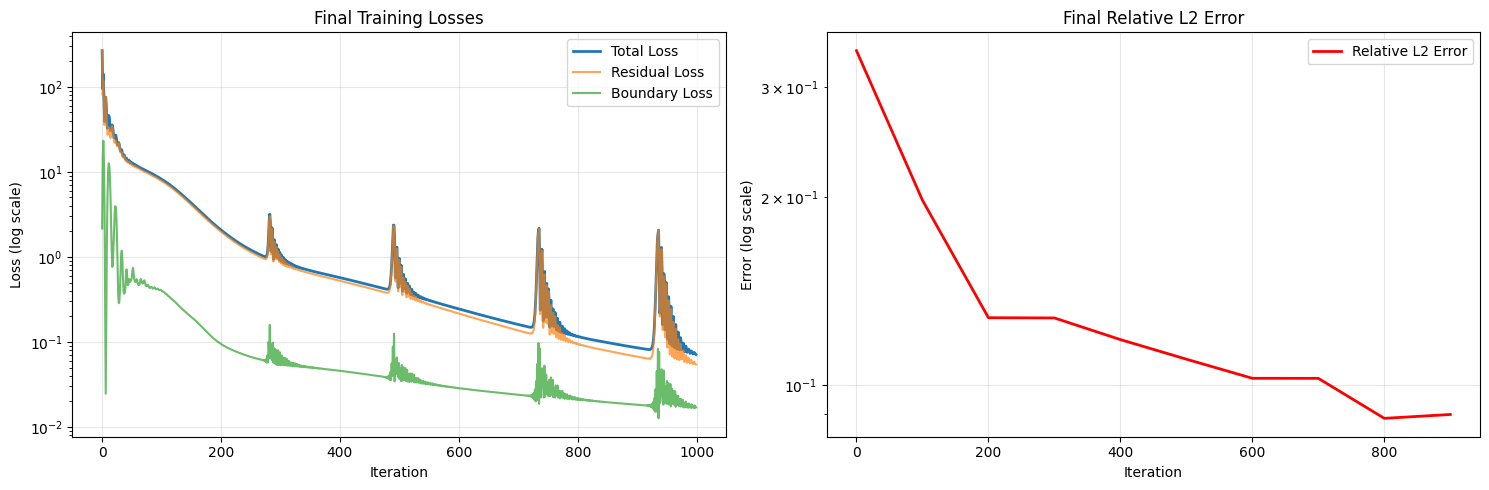


📊 Best solution:


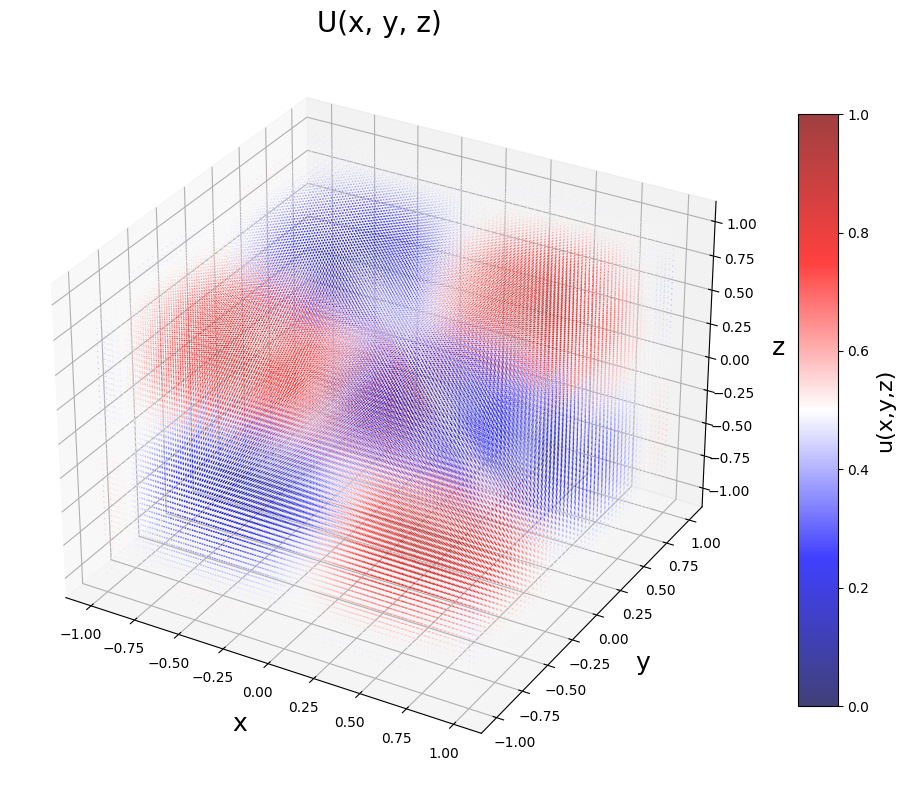

In [ ]:
history, best_error, best_u = train_spinn(
    model=model,
    optimizer=optimizer,
    x_test=xx_test,
    y_test=yy_test,
    z_test=zz_test,
    u_test=u_test,
    epochs=EPOCHS,
    log_iter=LOG_ITER,
    resample_iter=RESAMPLE_ITER,
    NC=NC,
    domain_size=1.0,
    device=device
)

Hint:

1. Проверьте размерности, чтобы точно сходились.

2. Поиграйтесь с перевзвешиванием лоссов.

3. Чтобы дополнительно понизить MSE, попробуйте поменять train функцию. Но не используйте MSE Loss от данных, за это бан.

In [ ]:
mse = ((u_test.cpu().numpy() - best_u.cpu().numpy()) ** 2).mean()

assert mse <= 5e-3 # 0.5 * 2 балла
assert mse <= 5e-4 # 0.6 * 2 балла
assert mse <= 1e-5 # 0.7 * 2 балла
assert mse <= 5e-6 # 0.8 * 2 балла
assert mse <= 1e-7 # 0.9 * 2 балла
assert mse <= 5e-8 # 1 * 2 балла

> Не забудьте сохранить веса модели - их нужно будет отправить ассистенту на проверку.

## Задание 2. Классификация звуков

### Введение в обработку аудио

#### Почему нельзя просто использовать "сырые" аудиосигналы?

Аудиосигналы - это непрерывные волны изменений звукового давления во времени. При оцифровке они превращаются в последовательности амплитудных значений, отсчётов, равномерно взятых во времени (например, 22 050 отсчётов в секунду). Теоретически, можно подавать исходные волны напрямую в нейронные сети, но такой подход сталкивается с рядом проблем:

1. **Высокая размерность**. 4-секундный аудиофрагмент с частотой 22 кГц содержит 88 000 отсчётов.
2. **Сложная временная структура**. Последовательная природа сигнала затрудняет одновременное захватывание локальных и глобальных паттернов.
3. **Нет явной информации о частотах**. В сыром сигнале не видно, какие частоты присутствуют.

#### Спектрограммы:

Спектрограмма - это визуальное представление частотного спектра сигнала во времени. Она преобразует 1D аудио в 2D-картинку, где:
- Ось X: время.
- Ось Y: частота.
- Интенсивность цвета: амплитуда (энергия) каждой частоты в конкретный момент времени.

Спектрограммы строятся с помощью **Кратковременного Преобразования Фурье (STFT)**, которое:
1. Делит аудио на короткие перекрывающиеся окна.
2. Применяет преобразование Фурье к каждому окну, чтобы извлечь частотную информацию.
3. Объединяет частотные срезы, показывая, как спектр меняется со временем.

### Мел-спектрограмма: Аудио через призму человеческого слуха

Обычные спектрограммы полезны, но не соответствуют тому, как человек воспринимает звук. Мел-спектрограммы устраняют это с помощью двух ключевых преобразований:

##### 1. Мел-шкала (ось частот)
Человек не воспринимает частоты линейно. Мы более чувствительны к изменениям в низких частотах, чем в высоких:
- Мы легко различаем 100 Гц и 200 Гц (разница 100 Гц).
- Но частоты 10 000 Гц и 10 100 Гц звучат почти одинаково (та же разница 100 Гц!).

**Мел-шкала** - это перцептивная шкала, соответствующая восприятию высоты тона человеком. Она приблизительно логарифмическая:

$$\text{mel}(f) = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)$$

##### Децибельная шкала (амплитуда/цвет)
Аналогично, мы воспринимаем громкость логарифмически, а не линейно. **Шкала децибел (дБ)** это отражает:

$$\text{dB} = 20 \cdot \log_{10}(\text{amplitude})$$

#### Почему мел-спектрограммы хороши для глубокого обучения?

1. Уменьшение размерности. Сжимаем с тысяч частотных бинов до ~128 мел-диапазонов
2. Психоакустическая релевантность. Оставляем только те частоты, которые важны для человека
3. Удобство для сверточных сетей. 2D-картинка идеально подходит для архитектур CNN
4. Проверена на практике. Современные результаты на задачах аудиоклассификации

![Пример мел-спектрограммы](https://manual.audacityteam.org/m/images/e/ed/mel_log_linear_spectrogram_annotated.png)

*Пример мел-спектрограммы: ось X - время, ось Y - частота по мел-шкале, цвет отражает амплитуду (от тёмных = низкая энергия до ярких = высокая энергия)*

Источники - [курс DLA](https://github.com/markovka17/dla), [audacity](https://manual.audacityteam.org/man/spectrogram_view.html)

## UrbanSound8K



Мы будем работать с датасет UrbanSound8K (US8K).

8732 размеченных фрагмента урбан-звуков (≤ 4 с), 10 классов: `air_conditioner`, `car_horn`, `children_playing`, `dog_bark`, `drilling`, `engine_idling`, `gun_shot`, `jackhammer`, `siren`, `street_music`.

Разбит на 10 фолдов для кросс-валидации; в этом ноутбуке используем "канонично": фолды 1–8 → train, 9 → val, 10 → test.

Скачиваем UrbanSound8K отсюда https://urbansounddataset.weebly.com/urbansound8k.html

Структура датасета:
```
UrbanSound8K/
├── audio/
│   ├── fold1/
│   ├── fold2/
│   └── ...
└── metadata/
    └── UrbanSound8K.csv
```

Давайте скачаем

In [ ]:
dataset = soundata.initialize('urbansound8k')
dataset.download()
dataset.validate()

example_clip = dataset.choice_clip()
print(example_clip)

In [ ]:
DATASET_PATH = '/sound_datasets/urbansound8k'

# Загрузим метаданные
metadata = pd.read_csv(os.path.join(DATASET_PATH, 'metadata', 'UrbanSound8K.csv'))

print(f"Всего примеров: {len(metadata)}")
print(f"\nРаспределение по классам:")
print(metadata['class'].value_counts().sort_index())

metadata.head()

Всего примеров: 8732

Распределение по классам:
class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#### Провизуализируем аудио

Sample: 171305-7-17-0.wav
Class: jackhammer
Fold: 4



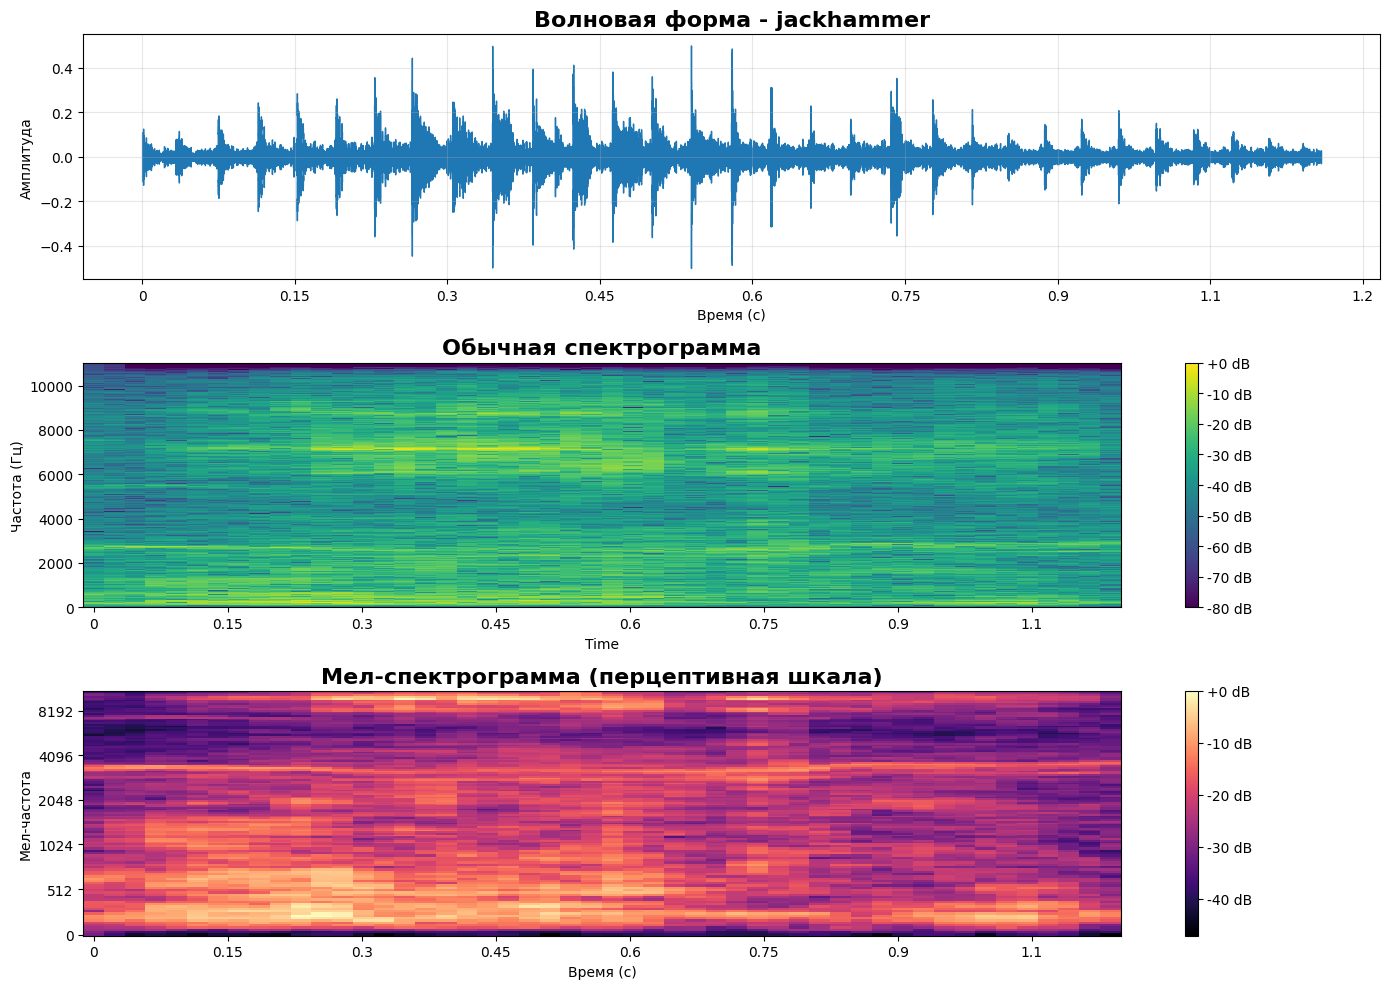


🔊 Послушай аудио ниже:


In [ ]:
def plot_waveform_and_spectrogram(audio_path, class_name):
    """
    Загрузим аудио и отобразим:
    1. Волну (форма сигнала)
    2. Обычный спектрограмму
    3. Мел-спектрограмму
    """
    # Как работаем с либросой
    y, sr = librosa.load(audio_path, sr=22050)

    fig, axes = plt.subplots(3, 1, figsize=(14, 10))

    # 1. Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title(f'Волновая форма - {class_name}', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Время (с)')
    axes[0].set_ylabel('Амплитуда')
    axes[0].grid(True, alpha=0.3)

    # 2. Обычная спектрограмма
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img1 = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1], cmap='viridis')
    axes[1].set_title('Обычная спектрограмма', fontsize=16, fontweight='bold')
    axes[1].set_ylabel('Частота (Гц)')
    fig.colorbar(img1, ax=axes[1], format='%+2.0f dB')

    # 3. Мел-спектрограмма
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img2 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[2], cmap='magma')
    axes[2].set_title('Мел-спектрограмма (перцептивная шкала)', fontsize=16, fontweight='bold')
    axes[2].set_ylabel('Мел-частота')
    axes[2].set_xlabel('Время (с)')
    fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    return y, sr


# Возьмем случайный пример
random_idx = np.random.randint(0, len(metadata))
sample = metadata.iloc[random_idx]

audio_path = os.path.join(DATASET_PATH, 'audio', f'fold{sample.fold}', sample.slice_file_name)
class_name = sample['class']

print(f"Sample: {sample.slice_file_name}")
print(f"Class: {class_name}")
print(f"Fold: {sample.fold}\n")

# Заплотим визуализации
y, sr = plot_waveform_and_spectrogram(audio_path, class_name)

# Проиграем аудио
print("\nПослушай аудио ниже:")
Audio(y, rate=sr)

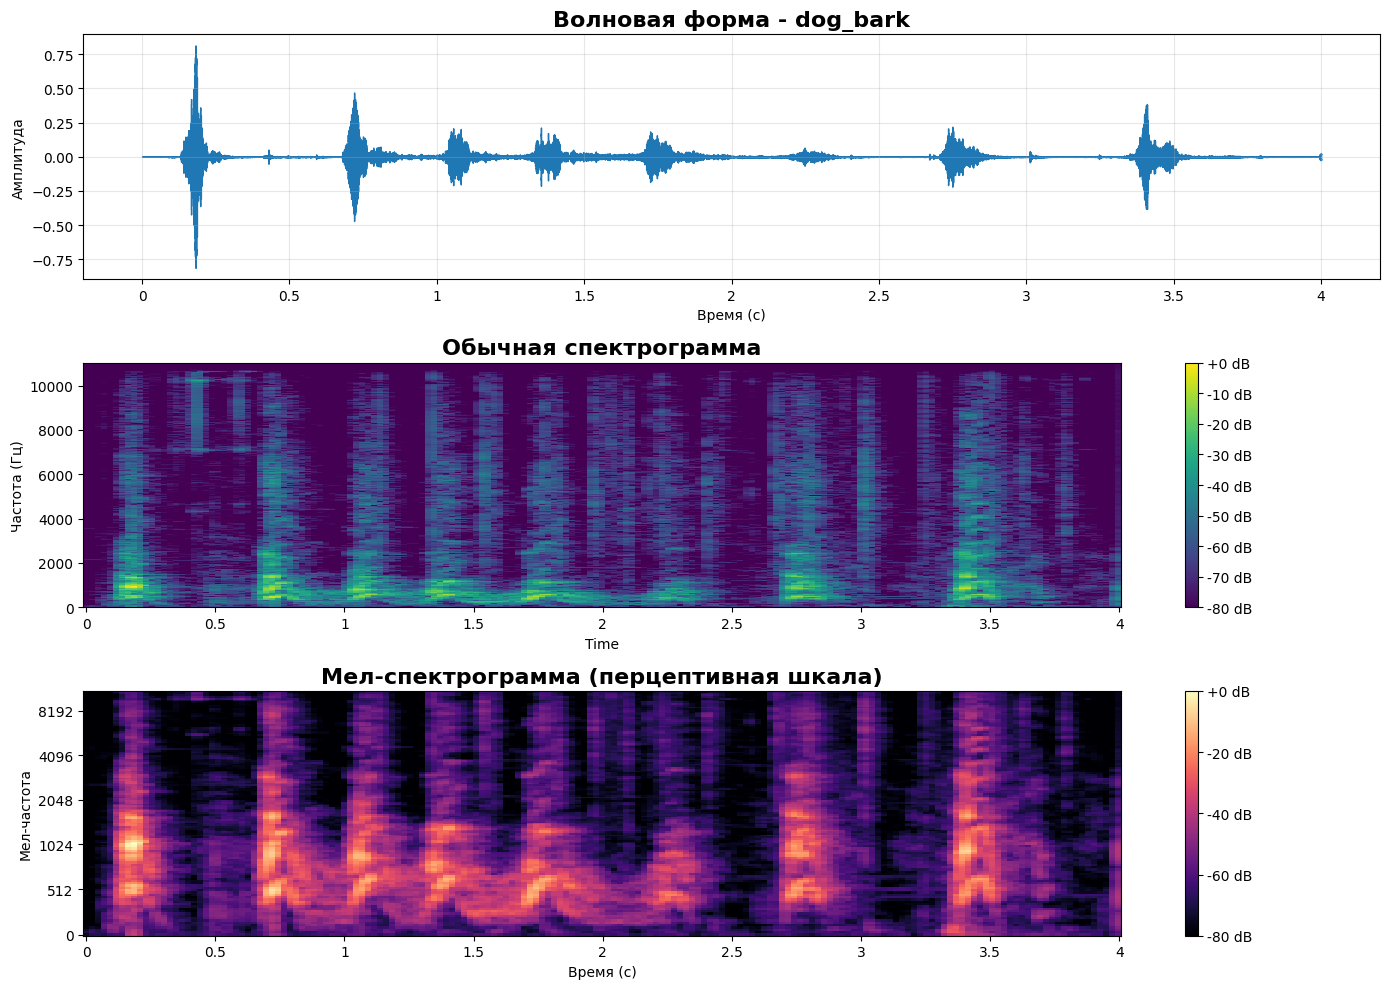

In [ ]:
target_class = 'dog_bark'

class_samples = metadata[metadata['class'] == target_class]
sample = class_samples.sample(1).iloc[0]

audio_path = os.path.join(DATASET_PATH, 'audio', f'fold{sample.fold}', sample.slice_file_name)
y, sr = plot_waveform_and_spectrogram(audio_path, target_class)

Audio(y, rate=sr)

### Задание 2.1 Подготовьте датасет к обучению модели (1 балл)

Рекомендуемые шаги и лайфхаки:
- Начните с чтения метаданных: убедитесь, что вы индексируете `DataFrame` заново и понимаете, где лежат файлы.
- Заведи́те несколько констант в `__init__`, чтобы не передавать аргументы по цепочке вручную.
- Используйте `pathlib` или `os.path.join` для сборки путей, чтобы не ошибиться со слэшами.
- Проверяйте загрузку аудио на коротких и длинных файлах: правильная нормализация длины избавит от `shape mismatch`.
- Для отладки удобно визуализировать одну мел-спектрограмму: посмотрите, что у вас "сходится", прежде чем запускать обучение.
- Аугментации делайте детерминированными через фиксированный `seed` при отладке, чтобы воспроизводить ошибки.
- После реализации обязательно протестируйте `__len__` и `__getitem__` вручную: возьмите 2–3 индекса и сравните метки с исходным metadata.

In [ ]:
class UrbanSoundDataset(Dataset):
    def __init__(self, metadata, dataset_path, target_length=4, sr=22050, n_mels=128, augment=False):
        """
        TODO: сохранить входные параметры как атрибуты и подготовить вспомогательные структуры.
        Подсказки:
        - нормализуйте индекс metadata, чтобы удобно обращаться по номеру
        - посчитайте целевое число сэмплов аудио (target_length * sr)
        - настройте LabelEncoder: fit_transform по столбцу 'class', сохраните классы и их количество
        - при желании можно выводить информацию о датасете (кол-во сэмплов, список классов)
        """
        raise NotImplementedError("Инициализация датасета")

    def __len__(self):
        """
        TODO: вернуть количество доступных сэмплов.
        Подсказка: используйте длину сохранённого DataFrame.
        """
        raise NotImplementedError("Метод __len__")

    def load_audio(self, file_path):
        """
        TODO: загрузить аудио с помощью librosa.load с нужной частотой дискретизации и длительностью.
        Подсказки:
        - если сигнал короче нужной длины, дополните нулями (np.pad)
        - если длиннее — обрежьте до target_samples
        - верните обработанный сигнал numpy-массивом
        """
        raise NotImplementedError("Загрузка аудио")

    def extract_mel_spectrogram(self, y):
        """
        TODO: построить мел-спектрограмму (librosa.feature.melspectrogram) и перевести в dB.
        Подсказки:
        - используйте сохранённые параметры sr, n_mels, фиксируйте n_fft, hop_length, fmax
        - нормализуйте мел-спектрограмму при необходимости в __getitem__
        """
        raise NotImplementedError("Извлечение мел-спектрограммы")

    def augment_audio(self, y):
        """
        TODO: реализовать опциональные аугментации (выполнять только при обучении).
        Идеи:
        - случайный сдвиг сигнала (np.roll) на диапазон [-sr, sr]
        - добавление белого шума (np.random.randn)
        Верните модифицированный сигнал.
        """
        raise NotImplementedError("Аугментация аудио")

    def __getitem__(self, idx):
        """
        TODO: собрать один элемент выборки.
        Шаги:
        1. Найдите строку metadata по idx и сформируйте path: dataset_path/audio/fold{row.fold}/row.slice_file_name
        2. Загрузите аудио через load_audio
        3. При включённой аугментации примените augment_audio
        4. Постройте мел-спектрограмму, нормализуйте (z-score) и превратите в torch.FloatTensor
        5. Добавьте размерность канала (unsqueeze(0))
        6. Верните пару (мел-спектрограмма, метка класса) где метка — torch.LongTensor
        """
        raise NotImplementedError("Возврат пары (мел-спектрограмма, метка)")

In [ ]:
test_fold = 10
test_df = metadata[metadata['fold'] == test_fold]
train_val_df = metadata[metadata['fold'] != test_fold]

train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42, stratify=train_val_df['class'])

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 6710
Validation samples: 1185
Test samples: 837


In [ ]:
train_dataset = UrbanSoundDataset(train_df, DATASET_PATH, augment=True)
val_dataset = UrbanSoundDataset(val_df, DATASET_PATH, augment=False)
test_dataset = UrbanSoundDataset(test_df, DATASET_PATH, augment=False)

# BATCH_SIZE = 32
BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Датасет инициализирован, количество сэмплов: 6710
Классы: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
Датасет инициализирован, количество сэмплов: 1185
Классы: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
Датасет инициализирован, количество сэмплов: 837
Классы: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

Batch size: 1024
Train batches: 7
Val batches: 2
Test batches: 1


In [ ]:
sample_batch, sample_labels = next(iter(train_loader))
print(f"Batch shape: {sample_batch.shape}")  # (batch_size, 1, n_mels, time)
print(f"Labels shape: {sample_labels.shape}")
print(f"Sample label values: {sample_labels[:5]}")

Batch shape: torch.Size([1024, 1, 128, 173])
Labels shape: torch.Size([1024])
Sample label values: tensor([7, 4, 4, 5, 5])


### Задание 2.2. Реализуйте вашу архитектуру (1 балл)

> Важно! Не допускаются rnn, lstm, трансформерные модели и прочие. **Только CNN**.

In [ ]:
class UrbanSoundCNN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5, channels=[1, 32, 64, 128, 256], fc_dim=128):
        # TODO: Реализуйте инициализацию слоев вашей архитектуры
        pass

    def forward(self, x):
        # TODO: Реализуйте forward вашей архитектуры
        pass

### 2.3. Реализуйте ваш код обучения и валидации модели (1 балл)

In [ ]:
# TODO: Реализуйте функцию train_epoch(model, loader, criterion, optimizer, device)
# TODO: Реализуйте функцию validate(model, loader, criterion, device)

In [ ]:
model = UrbanSoundCNN(num_classes=train_dataset.num_classes).to(device)

# Считаем параметры
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(model)

criterion = # TODO
optimizer = # TODO
scheduler = # TODO

In [ ]:
NUM_EPOCHS = 50
PATIENCE = 15  # Для ранней остановки

# Отслеживание истории обучения
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0

print(f"Starting training for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)

    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Валидация
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Обновляем learning rate
    scheduler.step(val_loss)

    # Сохраняем историю
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Сохраняем лучшую модель
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*60}")
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Лосс
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Валидация модели

In [ ]:
# Загружаем лучшую модель

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_acc = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\n{'='*60}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"{'='*60}\n")

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.label_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

In [ ]:
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100


plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(class_names)), per_class_acc, color='steelblue', alpha=0.7)
plt.axhline(y=test_acc, color='red', linestyle='--', label=f'Average Accuracy: {test_acc:.2f}%', linewidth=2)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{per_class_acc[i]:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Разбалловка части с метрикой

assert test_acc >= 0.7 # 0.5 * 3 баллов
assert test_acc >= 0.75 # 0.6 * 3 баллов
assert test_acc >= 0.8 # 0.7 * 3 баллов
assert test_acc >= 0.85 # 0.8 * 3 баллов
assert test_acc >= 0.9 # 0.9 * 3 баллов
assert test_acc >= 0.95 # 1 * 3 баллов
print(f"Accuracy: {test_acc:.4f}")

> Не забудьте сохранить веса модели - их нужно будет отправить ассистенту на проверку.